## Note
The paramters in this sample code are similar to  our main training code but we test this code on limited number of data for the sake of speed


## Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Data directory 

In [ ]:
import glob
import os
import numpy as np
from tqdm import tqdm

folder_npy = '/content/drive/My Drive/CovidCTNet/preprocessed/ct-normal-slices-train/'

file_paths = glob.glob(os.path.join(folder_npy, '*.npy'))
file_paths.sort()
print(file_paths)
print(len(file_paths))

['/content/drive/My Drive/CovidCTNet/preprocessed/ct-normal-slices-train/CPCR_0001_300_330_330_CR_1641266+.npy', '/content/drive/My Drive/CovidCTNet/preprocessed/ct-normal-slices-train/CPCR_0002_147_220_220_CR_1641392+.npy', '/content/drive/My Drive/CovidCTNet/preprocessed/ct-normal-slices-train/H_0001_330_380_380_PATIENT 2 (4).npy', '/content/drive/My Drive/CovidCTNet/preprocessed/ct-normal-slices-train/H_0002_310_348_348_PATIENT 2 (5).npy', '/content/drive/My Drive/CovidCTNet/preprocessed/ct-normal-slices-train/P_0001_310_384_384_Patient_23.npy', '/content/drive/My Drive/CovidCTNet/preprocessed/ct-normal-slices-train/P_0002_280_380_380_Patient_29.npy']
6


In [ ]:
# Splite data for Health or Control (h) class
h_path = file_paths[2:4]
print(h_path)

['/content/drive/My Drive/CovidCTNet/preprocessed/ct-normal-slices-train/H_0001_330_380_380_PATIENT 2 (4).npy', '/content/drive/My Drive/CovidCTNet/preprocessed/ct-normal-slices-train/H_0002_310_348_348_PATIENT 2 (5).npy']


## BCDU-net

In [ ]:
from __future__ import division
from keras.models import Model
from keras.layers import Input
from keras.layers import concatenate
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import UpSampling2D
from keras.layers import Reshape
from keras.layers import core
from keras.layers import Dropout
from keras.layers import Conv2DTranspose
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import ConvLSTM2D
from keras.optimizers import Adam
    
def BCDU_net_D3(input_size = (128,128,1)):
    N = input_size[0]
    inputs = Input(input_size) 
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    # D1
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)     
    conv4_1 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4_1 = Dropout(0.5)(conv4_1)
    # D2
    conv4_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop4_1)     
    conv4_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_2)
    conv4_2 = Dropout(0.5)(conv4_2)
    # D3
    merge_dense = concatenate([conv4_2,drop4_1], axis = 3)
    conv4_3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge_dense)     
    conv4_3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_3)
    drop4_3 = Dropout(0.5)(conv4_3)
    
    up6 = Conv2DTranspose(128, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(drop4_3)
    up6 = BatchNormalization(axis=3)(up6)
    up6 = Activation('relu')(up6)

    x1 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 128))(drop3)
    x2 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 128))(up6)
    merge6  = concatenate([x1,x2], axis = 1) 
    merge6 = ConvLSTM2D(filters = 64, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal')(merge6)
            
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2DTranspose(64, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv6)
    up7 = BatchNormalization(axis=3)(up7)
    up7 = Activation('relu')(up7)

    x1 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 64))(conv2)
    x2 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 64))(up7)
    merge7  = concatenate([x1,x2], axis = 1) 
    merge7 = ConvLSTM2D(filters = 32, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge7)
        
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2DTranspose(32, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv7)
    up8 = BatchNormalization(axis=3)(up8)
    up8 = Activation('relu')(up8)    

    x1 = Reshape(target_shape=(1, N, N, 32))(conv1)
    x2 = Reshape(target_shape=(1, N, N, 32))(up8)
    merge8  = concatenate([x1,x2], axis = 1) 
    merge8 = ConvLSTM2D(filters = 16, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge8)    
    
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv9 = Conv2D(1, 1, activation = 'sigmoid')(conv8)

    model = Model(inputs, conv9)
    return model

In [ ]:
model = BCDU_net_D3(input_size = (128,128,1))
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 128, 128, 32) 320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 128, 128, 32) 9248        conv2d_32[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 64, 64, 32)   0           conv2d_33[0][0]                  
_______________________________________________________________________________________

### Resizing the slices for BCDUNet model

In [ ]:
from skimage.transform import resize

In [ ]:
output = np.zeros((1,128,128))
for i in tqdm(h_path):
    data = np.load(i)
    data = resize(data, (data.shape[0],128, 128),anti_aliasing=True)
    output = np.append(output,data,axis=0)
output = output[1:]

100%|██████████| 2/2 [00:07<00:00,  3.84s/it]


### Adding noise

In [ ]:
!pip install noise

     |████████████████████████████████| 133kB 2.6MB/s 
  Created wheel for noise: filename=noise-1.2.2-cp36-cp36m-linux_x86_64.whl size=62466 sha256=7584d1c8765a58094b26c95160b24dea7e6d557b9ecec66ba5cb3a836a3eea99
  Stored in directory: /root/.cache/pip/wheels/fd/a3/c1/d36defe6e9f074b25dc0f018eb9f8fdd675a7ef87071ce3821
Successfully built noise


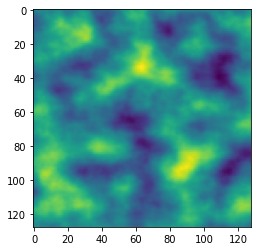

In [ ]:
import noise
import cv2

def add_noise(input_array):
    shape = (128,128)
    scale = np.random.randint(10,30)
    # scale = 12
    # scale = 30
    octaves = 10
    persistence = 0.01*np.random.randint(-50,50)
    # persistence = 0.1
    lacunarity = 2.0
    seed = np.random.randint(0,1000)
    # seed = 33
    world = np.zeros(shape)
    for i in range(shape[0]):
        for j in range(shape[1]):
            world[i][j] = noise.pnoise2(i/scale, 
                                        j/scale, 
                                        octaves=octaves, 
                                        persistence=persistence, 
                                        lacunarity=lacunarity, 
                                        repeatx=140, 
                                        repeaty=140, 
                                        base=seed)
    return cv2.addWeighted(input_array, 1, world, 1, 0)  

import matplotlib.pyplot as plt
a  = np.zeros((128,128))
plt.imshow(add_noise(a)) 

In [ ]:
from tqdm import tqdm
noisy_output = np.zeros(output.shape)
for i in tqdm(range(output.shape[0])):
    noisy_output[i] = add_noise(output[i,:,:])

100%|██████████| 640/640 [00:17<00:00, 36.03it/s]


In [ ]:
'''
Change half of data to original slices (without noise)
Suggestion: you can use random permutation to clean half of data
suggestyion: you can change the rate of being nosisy or clean! 
'''
noisy_output[int(noisy_output.shape[0]/2):] = output[int(noisy_output.shape[0]/2):]

In [ ]:
#target (without noise)
output = np.reshape(output,(output.shape[0],output.shape[1],output.shape[2],1))

#input (half noisy)
noisy_output = np.reshape(noisy_output,(noisy_output.shape[0],noisy_output.shape[1],noisy_output.shape[2],1))

### Training the model

In [ ]:
model.compile(optimizer = Adam(lr = 1e-3), loss = 'binary_crossentropy')

In [ ]:
history = model.fit(noisy_output, output,
            batch_size = 5,
            epochs = 3,
            shuffle=True,
            verbose=1)

Epoch 1/3
128/128 [==============================] - 7s 57ms/step - loss: 0.4213
Epoch 2/3
128/128 [==============================] - 7s 57ms/step - loss: 0.3654
Epoch 3/3
128/128 [==============================] - 7s 57ms/step - loss: 0.3545


In [ ]:
'''
However, you can save weights of your model for future use
'''
# model.save_weights('/content/drive/My Drive/covidctnet-master/Model_weight/weight_half_lung_noisy.hdf5')
# model.load_weights('/content/drive/My Drive/covidctnet-master/Model_weight/weight_half_lung_noisy.hdf5')

## 3D CNN model

In [ ]:
'''
Load all data to pass through BCDUNet to bold infections in out pipeline
Splite data for each class of COVID (c), Health or Control (h) and Pneumonia or CAP (p)

'''
c_path = file_paths[:2]
h_path = file_paths[2:4]
p_path = file_paths[4:6]
my_file_paths = c_path+h_path+p_path
print(my_file_paths)
print(len(my_file_paths))


['/content/drive/My Drive/CovidCTNet/preprocessed/ct-normal-slices-train/CPCR_0001_300_330_330_CR_1641266+.npy', '/content/drive/My Drive/CovidCTNet/preprocessed/ct-normal-slices-train/CPCR_0002_147_220_220_CR_1641392+.npy', '/content/drive/My Drive/CovidCTNet/preprocessed/ct-normal-slices-train/H_0001_330_380_380_PATIENT 2 (4).npy', '/content/drive/My Drive/CovidCTNet/preprocessed/ct-normal-slices-train/H_0002_310_348_348_PATIENT 2 (5).npy', '/content/drive/My Drive/CovidCTNet/preprocessed/ct-normal-slices-train/P_0001_310_384_384_Patient_23.npy', '/content/drive/My Drive/CovidCTNet/preprocessed/ct-normal-slices-train/P_0002_280_380_380_Patient_29.npy']
6


### Go Through BCDUNet all slices and pack them

In [ ]:
'''
Here, we:
1- Resize different size of slices (2D) -> in x,y axes
2- Predict all slices of a patient using BCDUNET
3- Do subtraction
1- Resize different size of CT images (3D) -> in z axis
'''


from scipy import signal

dataset = np.zeros((len(my_file_paths),50,128,128))
counter = 0
for j in tqdm(my_file_paths):
    print(j)
    CT = np.load(j)
    CT_resized = resize(CT, (CT.shape[0],128, 128),anti_aliasing=True)
    out = model.predict(np.reshape(CT_resized,(CT_resized.shape[0],CT_resized.shape[1],CT_resized.shape[2],1)))
    c = CT_resized-out[:,:,:,0]
    dataset[counter] = resize(c,(50,128,128))
    counter +=1

  0%|          | 0/6 [00:00<?, ?it/s]

/content/drive/My Drive/CovidCTNet/preprocessed/ct-normal-slices-train/CPCR_0001_300_330_330_CR_1641266+.npy


 17%|█▋        | 1/6 [00:02<00:11,  2.34s/it]

/content/drive/My Drive/CovidCTNet/preprocessed/ct-normal-slices-train/CPCR_0002_147_220_220_CR_1641392+.npy


 33%|███▎      | 2/6 [00:03<00:08,  2.11s/it]

/content/drive/My Drive/CovidCTNet/preprocessed/ct-normal-slices-train/H_0001_330_380_380_PATIENT 2 (4).npy


 50%|█████     | 3/6 [00:07<00:07,  2.43s/it]

/content/drive/My Drive/CovidCTNet/preprocessed/ct-normal-slices-train/H_0002_310_348_348_PATIENT 2 (5).npy


 67%|██████▋   | 4/6 [00:09<00:05,  2.52s/it]

/content/drive/My Drive/CovidCTNet/preprocessed/ct-normal-slices-train/P_0001_310_384_384_Patient_23.npy


 83%|████████▎ | 5/6 [00:14<00:03,  3.30s/it]

/content/drive/My Drive/CovidCTNet/preprocessed/ct-normal-slices-train/P_0002_280_380_380_Patient_29.npy


100%|██████████| 6/6 [00:20<00:00,  3.34s/it]


### Prepare labels

In [ ]:
'''
Based on the name of files (C: COVID, H: Health or Control, P: Pneumonia or CAP)
'''
lbl = np.zeros((6))
lbl[0:2] = 1 #COVID
lbl[2:4] = 0 #Control
lbl[4:6] = 2 #CAP
print(lbl)

[1. 1. 0. 0. 2. 2.]


In [ ]:
'''
For saving the RAM, you can save the data and restart you runtime.
please import librarys again to continue
'''
# np.save('/content/drive/My Drive/covidctnet-master/Data_step1/diff_dataset.npy',dataset)
# np.save('/content/drive/My Drive/covidctnet-master/Data_step1/diff_lbl.npy',lbl)

### 3D CNN training

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D,Dropout
from keras.utils import to_categorical
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# dataset = np.load('/content/drive/My Drive/covidctnet-master/Data_step1/diff_dataset.npy')
# lbl = np.load('/content/drive/My Drive/covidctnet-master/Data_step1/diff_lbl.npy')

In [ ]:
# reshape the dataset to feed to the model
dataset = np.reshape(dataset,(dataset.shape[0],dataset.shape[1],dataset.shape[2],dataset.shape[3],1))

In [ ]:
# for balancing data as the inputs of the model
c = np.random.permutation(np.arange(0,2))
h = np.random.permutation(np.arange(2,4))
p = np.random.permutation(np.arange(4,6))

train_index = np.random.permutation(np.append(np.append(c[0:1],h[0:1]),p[0:1]))
print('training set:', train_index)
validation_index = np.random.permutation(np.append(np.append(c[1:2],h[1:2]),p[1:2]))
print('validation set:',validation_index)

training set: [2 0 4]
validation set: [5 1 3]


In [ ]:
# Convert target vectors to categorical targets
targets_train = to_categorical(lbl[train_index]).astype(np.integer)
targets_validation = to_categorical(lbl[validation_index]).astype(np.integer)

In [ ]:
model = Sequential()
model.add(Conv3D(8, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(50,128,128,1)))
model.add(Conv3D(8, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
model.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_10 (Conv3D)           (None, 48, 126, 126, 8)   224       
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 48, 126, 126, 8)   1736      
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 24, 63, 63, 8)     0         
_________________________________________________________________
conv3d_12 (Conv3D)           (None, 24, 63, 63, 16)    3472      
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 24, 63, 63, 16)    6928      
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 12, 31, 31, 16)    0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 12, 31, 31, 32)   

In [ ]:
# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy, # or 'mse'
              optimizer=keras.optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])


In [ ]:
# Fit data to model
history = model.fit(dataset[train_index], targets_train,
            batch_size=16, # batch_size = 16 in paper
            epochs=2, # epochs = 100 in paper
            verbose=1,
            shuffle = True,
            validation_data = (dataset[validation_index],targets_validation))

Epoch 1/2
1/1 [==============================] - 0s 188ms/step - loss: 0.4940 - accuracy: 1.0000 - val_loss: 0.9823 - val_accuracy: 0.6667
Epoch 2/2
1/1 [==============================] - 0s 152ms/step - loss: 0.6012 - accuracy: 1.0000 - val_loss: 0.9740 - val_accuracy: 0.6667


In [ ]:
from sklearn import metrics
matrix = metrics.confusion_matrix(targets_validation.argmax(axis=1), model.predict(dataset[validation_index]).argmax(axis=1))
print(matrix)

[[1 0 0]
 [0 0 1]
 [0 0 1]]


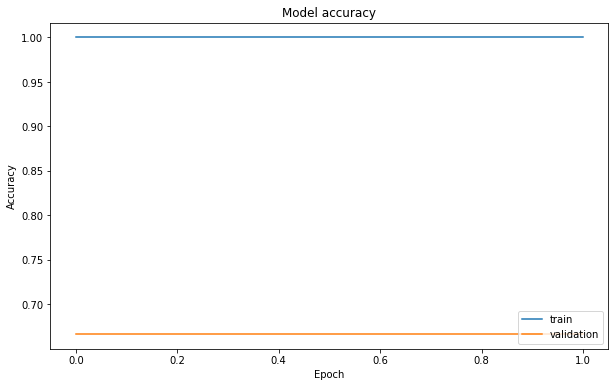

In [ ]:
import keras
from matplotlib import pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

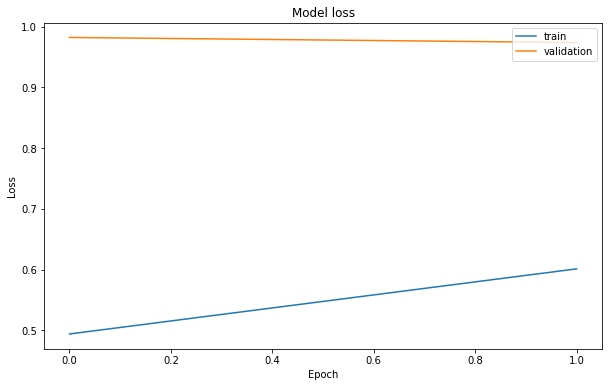

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### saving

In [ ]:
from keras.models import model_from_json

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# model.save_weights("/content/drive/My Drive/covidctnet-master/Model_weight/weight_cnn_CovidCtNet2d.h5")